This notebook provides implementation of an inference technique for inhomogenuous poisson process using thinned events. For more details, please refer to Adams et al "Tractable Nonparametric Bayesian Inference in Poisson Processes with Gaussian Process Intensities"

In [1]:
import numpy as np
import GPy
import edward as ed
from kern import RBF, Periodic
import tensorflow as tf
from datasets import build_toy_dataset1, build_toy_dataset2
from matplotlib import pyplot as plt
from thinnedEvents import ThinnedEventsSolver, ThinnedEventsSampler

## Simulate data using Intensity function

> $$ \lambda_1(s) = 2 \exp\{-s/15\} + \exp\{-((s-25)/10)^2\}$$
> $$ \lambda_2(s) = 5 \sin(s^2) + 6$$

99


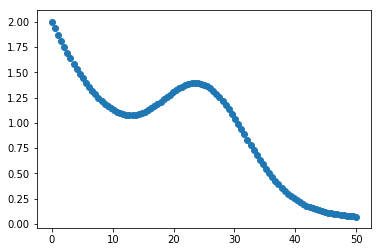

In [7]:
events, Z, N, rate, measure = build_toy_dataset1()
print(N)
kern = RBF(input_dim=1, lengthscale=1)
plt.scatter(events, Z)
plt.show()

In [8]:
sampler = ThinnedEventsSampler(events, kern, measure, rate)
x_K, y_K, x_M, y_M = sampler.run()

## Inference

The inference is done via a three step sampling procedure. Here, we consider that the Poisson data is generated from a random intensity function drawn from a gaussian process prior. The model is constructed by adding latent variables such as number of thinned events, their locations and the function values at those events. Finally, we run inference over the posterior of the function values given the latent variables.

Construct ThinnedEventsSolver object which takes the event locations and the covariance kernel as input.

In [ ]:
solver = ThinnedEventsSolver(events, kern, measure, rate)
S,G = solver.solve(n_iter = 20)

In [ ]:
plt.scatter(S, rate / (1 + np.exp(-G)))
plt.ylim((0, rate))
plt.show()

In [ ]:
def build_toy_dataset1():
    rate = 2
    measure = 50
    N = np.random.poisson(measure * rate)
    S = np.expand_dims(np.sort(np.linspace(0, measure, N)), axis = 1)
    Z = 2*np.exp(-S/15) + np.exp(-((S-25)/10)**2)
    print(N)
    return S, Z, N, rate, measure

def build_toy_dataset2():
    rate = 12
    measure = 5
    N = np.random.poisson(measure * rate)
    S = np.expand_dims(np.sort(np.linspace(0, measure, N)), axis = 1)
    Z = 5 * np.sin(S**2) + 6
    print(N)
    return S, Z, N, rate, measure


## Generate and plot data

In [ ]:
k = GPy.kern.PeriodicExponential(input_dim=1, period=5, variance=3)
S, Z, N, rate, measure = build_toy_dataset2()
plt.scatter(S, Z)
plt.show()

## Thinning events to keep data points consistent with the intensity function

In [ ]:
R = np.random.uniform(0, 1, N)
V = (Z / rate).flatten()
G = np.random.multivariate_normal(np.zeros((S.shape[0])), k.K(S, S))
accept = np.where(R < (1 / (1 + np.exp(-G))))
S_k  = np.take(S, accept, axis=0).reshape(-1,1)
Z_k  = np.take(Z, accept, axis=0).reshape(-1)
#G_k = np.log(Z_k / (rate - Z_k)).reshape(-1)
G_k = np.take(G, accept, axis=0).reshape(-1)#random.multivariate_normal(np.zeros((S_k.shape[0])), k.K(S_k,S_k))
#X = k.K(S_k, S_k)
plt.scatter(S_k, Z_k)
plt.show()
K = S_k.shape[0]
print(N,K)
plt.ylim((0,10))
plt.scatter(S_k, rate/(1+np.exp(-G_k)))
plt.show()

In [ ]:
#prior_loss = 0.5 * np.matmul(np.expand_dims(G_k, axis=0), np.matmul(np.linalg.inv(X + 1e-6*np.eye(K)), np.expand_dims(G_k, axis=1)))
prior_loss = 0.5 * np.matmul(np.expand_dims(G_k, axis=0), np.expand_dims(G_k, axis=1))
like_loss = np.sum(np.log(np.ones(K) + np.exp(-G_k)))
print(like_loss)
#likelihood_loss = tf.reduce_sum(tf.log(tf.ones([K]) + tf.exp(-tf.slice(F, [0], [K]))))
#likelihood_loss += tf.reduce_sum(tf.log(tf.ones([M]) + tf.exp(tf.slice(F, [K], [M]))))    
loss = prior_loss + like_loss
print(loss)

### Conditional for Gaussian process

In [ ]:
def conditional(x_new, x, y, k):

    B = k.K(x_new, x)
    C = k.K(x,x)
    A = k.K(x_new, x_new)
    N = len(C)
    mu = B.dot(np.linalg.inv(C + 1e-6*np.eye(N))).dot(y)
    sigma = A - B.dot(np.linalg.inv(C + 1e-6*np.eye(N)).dot(B.T))
    return(mu.squeeze(), sigma.squeeze())

In [ ]:
def update(x_K, y_K, x_M, y_M):
   
    bern_p = 0.5
    K = len(x_K)
    
    ### Sampling number of thinned events
    for i in range(10):
        b = bernoulli.rvs(bern_p, size=1)     # Sample from a bernoulli
        M = len(x_M)
        if b==1:
            x_new = np.random.uniform(low=0.0, high = measure, size=(1,1))   # Sample uniformly from the region
            
            mu_new, sigma_new = conditional(x_new, np.concatenate((x_K,x_M), axis=0), np.concatenate((y_K, y_M), axis=0), k)
            y_new = np.random.normal(loc=mu_new, scale=np.sqrt(sigma_new))
            
            ## Calculate insertion ratio
            ratio = np.log(rate * measure)
            ratio -= np.log(M + 1)
            ratio -= np.log(1 + np.exp(y_new))
            a = np.random.uniform(0, 1)
            
            if np.log(a) < ratio:
                x_M = np.concatenate((x_M, x_new), axis=0)
                y_M = np.concatenate((y_M, np.expand_dims(y_new, axis=1)))
        
        
        elif M>0:
            c = np.random.choice(M, 1)[0]    # Uniformly choose an event to delete
            
            ## Calculate deletion ratio
            ratio = np.log(M)
            ratio += np.log(1 + np.exp(y_M[c]))
            ratio -= np.log(rate * measure)
            a = np.random.uniform(0, 1)
            
            if np.log(a) < ratio:
                x_M = np.delete(x_M, c, 0)
                y_M = np.delete(y_M, c)


    ## Sampling the location of thinned events

    for i in range(len(x_M)):   # Use enumerate

        x_new = np.random.normal(loc=x_M[i], scale=np.sqrt(1.0*measure/100.0), size=(1,1))#np.random.uniform(low=0.0, high=measure, size=(1,1))    # Sample a new data point
        mu_new, sigma_new = conditional(x_new, np.concatenate((x_K,np.delete(x_M,i,axis=0)), axis=0), np.concatenate((y_K, np.delete(y_M,i,axis=0)), axis=0), k)
        y_new = np.random.normal(loc=mu_new, scale=np.sqrt(sigma_new))
        
        # Calculate the acceptance ratio
        ratio = np.log(1 + np.exp(y_M[i]))
        ratio -= np.log(1 + np.exp(y_new))

        a = np.random.uniform(0, 1)
        if np.log(a) < ratio:
            x_M[i] = x_new
            y_M[i] = y_new
            
    
    S = np.concatenate((x_K, x_M), axis=0)
    G = np.concatenate((y_K, y_M), axis=0)
    N = S.shape[0]       # Number of data points K+M
    D = S.shape[1]       # Dimension of the space
    M = len(x_M)
    C = k.K(S,S).astype(np.float32)
    #chol = np.linalg.cholesky(np.linalg.inv(C + 1e-6 * np.eye(N)))
    #G = np.matmul(chol, G)
    ## Learn function values via gradient optimization
    X = tf.constant(C)
    F = tf.Variable(G, name="FunctionVal", dtype=tf.float32)
    prior_loss = 0.5 * tf.matmul(tf.expand_dims(F, axis=0), tf.matmul(tf.matrix_inverse(X + 1e-6*tf.eye(N)), tf.expand_dims(F, axis=1)))
    #prior_loss = 0.5 * tf.matmul(tf.expand_dims(F, axis=0), tf.expand_dims(F, axis=1))
    prior_loss = tf.squeeze(prior_loss)
    likelihood_loss = tf.reduce_sum(tf.log(tf.ones([K]) + tf.exp(-tf.slice(F, [0], [K]))))
    likelihood_loss += tf.reduce_sum(tf.log(tf.ones([M]) + tf.exp(tf.slice(F, [K], [M]))))    
    loss = prior_loss + likelihood_loss
    train_op = tf.train.AdadeltaOptimizer(0.01,0.95,1e-5).minimize(loss)
    init_OP = tf.global_variables_initializer()
    max_it = 500
    with tf.Session() as sess:
        sess.run(init_OP)
        for i in range(max_it):
            err, _ = sess.run([loss, train_op])
        val = sess.run(F)
    print(err)
    y_K, y_M = val[:K], val[K:]
    return x_K, y_K, x_M, y_M, val, err

In [ ]:
n_iter = 30
x_K, y_K = S_k, G_k
x_M, y_M = np.empty((0,1)), np.empty((0))
errors = []     # List to maintain loss value at each iteration
for n in range(n_iter):
    
    x_K, y_K, x_M, y_M, val, err = update(x_K, y_K, x_M, y_M)
    print(x_M.shape)
    errors.append(err)

S = np.concatenate((x_K,x_M), axis=0)
plt.plot(np.arange(n_iter), errors)
#plt.scatter(S, rate / (1 + np.exp(-val)))
plt.show()

In [ ]:
print(S.shape, Z.shape)
                     
plt.xlim((0,5))
plt.scatter(S_k, Z_k)
plt.show()
plt.ylim((0,10))
plt.xlim((0,5))
plt.scatter(S, rate / (1 + np.exp(-val)))
plt.show()

# End of Relevant Code


# Junk Code below this cell. Please do not read.

In [ ]:
S = np.concatenate((x_K,x_M), axis=0)
print(x_K.shape, val.shape)
plt.scatter(x_K, rate / (1 + np.exp(-val[:K])))
plt.show()
print(k.K(S, S))
print(C)
print(rate, measure)

In [ ]:
print(len(x_K), len(x_M))

In [ ]:

K = len(x_K)
M = len(x_M)
print(N)
print(K,M)
plt.scatter(S, G)
plt.show()

In [ ]:
X = tf.constant(C)
F = tf.Variable(G, name="FunctionVal", dtype=tf.float32)

prior_loss = 0.5*tf.matmul(tf.expand_dims(F, axis=0), tf.matmul(tf.matrix_inverse(X + 1e-6*tf.eye(N)), tf.expand_dims(F, axis=1)))
prior_loss = tf.squeeze(prior_loss)

In [ ]:
#tf.ones(shape=[K])
#tf.slice(F, [0], [K])
likelihood_loss = tf.reduce_sum(tf.log(tf.ones([K]) + tf.exp(-tf.slice(F, [0], [K]))))
likelihood_loss += tf.reduce_sum(tf.log(tf.ones([M]) + tf.exp(tf.slice(F, [K], [M]))))    
loss = prior_loss + likelihood_loss
train_op = tf.train.AdadeltaOptimizer(0.01, 0.95, 1e-5).minimize(loss)
#train_op = tf.train.GradientDescentOptimizer(1e-7).minimize(loss)
init_OP = tf.global_variables_initializer()

In [ ]:
with tf.Session() as sess:
    sess.run(init_OP)
    l = sess.run(loss)
    print(l)
    for i in range(100):
        #print(sess.run(tf.gradients(loss, F)))
        sess.run(train_op)
        l = sess.run(loss)
        print(l)
        
    val = sess.run(F)
    
import tqdm

In [ ]:
plt.scatter(S, val)
plt.show()